In [60]:
!pip install pmdarima

In [61]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import pickle
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

# **ARIMA Model**

Check Stationarity Using ADF Test

ARIMA works well for stationary time series.


In [62]:
#load normallized data
df = pd.read_csv('/content/drive/MyDrive/Portfolio Management Optimization/data/closing_prices.csv', index_col='Date', parse_dates=True)

In [63]:
#check stationarity
tickers = ['TSLA', 'BND', "SPY"]
for ticker in tickers:
    result = adfuller(df[ticker])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Lag used: {result[2]}")
    print(f"Number of observation: {result[2]}")
    print(f"Critical Values': {result[4]}")

    if result[1] < 0.05:
        print(f"Data_{ticker} is stationary (No need for differencing)\n\n")
    else:
        print(f"Data_{ticker} is non-stationary (Differencing needed\n\n")

ADF Statistic: -0.5687280656291542
p-value: 0.8778928052253294
Lag used: 27
Number of observation: 27
Critical Values': {'1%': -3.4329610922579095, '5%': -2.8626935681060375, '10%': -2.567384088736619}
Data_TSLA is non-stationary (Differencing needed


ADF Statistic: -1.4722654899980527
p-value: 0.5471838887257311
Lag used: 24
Number of observation: 24
Critical Values': {'1%': -3.4329579682301254, '5%': -2.8626921885291017, '10%': -2.5673833542324727}
Data_BND is non-stationary (Differencing needed


ADF Statistic: 0.936226981746984
p-value: 0.9935453459083583
Lag used: 10
Number of observation: 10
Critical Values': {'1%': -3.4329434877271816, '5%': -2.862685793891119, '10%': -2.567379949649765}
Data_SPY is non-stationary (Differencing needed





# **Apply First-Order Differencing**

Since the data is non-stationary, we apply first-order differencing to make it stationary before using ARIMA.

In [64]:
for ticker in tickers:
    df[f'{ticker}_diff'] = df[ticker].diff()

    # Re-run ADF test on differenced data

    result_diff = adfuller(df[f'{ticker}_diff'].dropna())

    print(f"ADF Statistic (Differenced): {result_diff[0]}")
    print(f"p-value (Differenced): {result_diff[1]}")

    if result_diff[1] < 0.05:
        print("Data is now stationary (Differencing successful\n\n")
    else:
        print("Data is still non-stationary (Further differencing may be needed\n\n)")

ADF Statistic (Differenced): -9.770527081408877
p-value (Differenced): 7.15643871387649e-17
Data is now stationary (Differencing successful


ADF Statistic (Differenced): -10.056262014853882
p-value (Differenced): 1.3705224059689935e-17
Data is now stationary (Differencing successful


ADF Statistic (Differenced): -16.104303058041545
p-value (Differenced): 5.092267659326992e-29
Data is now stationary (Differencing successful




**Fit ARIMA Model**

In [65]:
def train_test_split(df):
    train_df=df[:round(len(df)*0.8)]
    test_df=df[round(len(df)*0.8):]

    return train_df,test_df
train_df,test_df=train_test_split(df)

In [66]:
forecasts = {}  # Dictionary to store forecasted values
results = {}  # Dictionary to store actual vs predicted dataframes

for ticker in tickers:
    # Fit ARIMA model
    arima_model = ARIMA(train_df[ticker], order=(1, 1, 1))
    model = arima_model.fit()

    # Forecast
    forecast_values = model.forecast(steps=len(test_df))

    # Store forecasted values
    forecasts[ticker] = forecast_values.values

    # Create a DataFrame for actual vs predicted
    actual_vs_prediction = test_df.copy()
    actual_vs_prediction['forecasted_Price'] = forecast_values.values  # Assign predicted values

    # Store actual vs predicted DataFrame
    results[ticker] = actual_vs_prediction

# Convert forecasts dictionary to DataFrame
forecasts_df = pd.DataFrame(forecasts)
print(forecasts_df)  # Check forecasted values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

           TSLA        BND         SPY
0    143.448061  68.626257  389.383667
1    143.593152  68.630422  389.472416
2    143.523431  68.633233  389.440972
3    143.556934  68.635130  389.452112
4    143.540835  68.636410  389.448165
..          ...        ...         ...
502  143.546060  68.639068  389.449198
503  143.546060  68.639068  389.449198
504  143.546060  68.639068  389.449198
505  143.546060  68.639068  389.449198
506  143.546060  68.639068  389.449198

[507 rows x 3 columns]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [67]:
# Dictionary to store results
forecasts = {}

for ticker in tickers:
    # Fit ARIMA model
    arima_model = ARIMA(train_df[ticker], order=(1, 1, 1))
    model = arima_model.fit()

    # Forecast
    forecast_values = model.forecast(steps=len(test_df))

    # Create a DataFrame to compare actual vs. predicted values
    actual_vs_prediction = pd.DataFrame({
        'True_Price': test_df[ticker].values,  # Actual prices
        'Predicted_Price': forecast_values.values  # Forecasted prices
    }, index=test_df.index)  # Keep the original index for alignment

    # Store DataFrame for this ticker
    forecasts[ticker] = actual_vs_prediction
    # save the model
    model.save(f'/content/drive/MyDrive/Portfolio Management Optimization/model/ARIMA_model_{ticker}.pkl')

# Convert the dictionary of DataFrames into a single DataFrame
forecasts_df = pd.concat(forecasts, axis=1)
ARIMA_forcasted_df = forecasts_df
# save data
ARIMA_forcasted_df.to_csv('/content/drive/MyDrive/Portfolio Management Optimization/data/ARIMA_forcasted_df.csv')
print(forecasts_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

                  TSLA                        BND                         SPY  \
            True_Price Predicted_Price True_Price Predicted_Price  True_Price   
Date                                                                            
2023-01-24  143.889999      143.448061  68.926559       68.626257  389.215973   
2023-01-25  144.429993      143.593152  69.010147       68.630422  389.361877   
2023-01-26  160.270004      143.523431  68.880135       68.633233  393.641083   
2023-01-27  177.899994      143.556934  68.805840       68.635130  394.545563   
2023-01-30  166.660004      143.540835  68.610809       68.636410  389.595306   
...                ...             ...        ...             ...         ...   
2025-01-24  406.579987      143.546060  71.592491       68.639068  607.969971   
2025-01-27  397.149994      143.546060  71.970123       68.639068  599.369995   
2025-01-28  398.089996      143.546060  71.930367       68.639068  604.520020   
2025-01-29  389.100006      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# **Model Metrics**

In [68]:
for ticker in tickers:
    # Calculate metrics
    mae = mean_absolute_error(test_df[ticker], forecasts_df[ticker]['Predicted_Price'])
    mse = mean_squared_error(test_df[ticker], forecasts_df[ticker]['Predicted_Price'])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_df[ticker] - forecasts_df[ticker]['Predicted_Price']) / test_df[ticker])) * 100
    # Print metrics
    print(f"Metrics for {ticker}:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R Square Score (r2_score):", r2_score)
    print("Mean Absolute Percentage Error (MAPE):", mape, "%\n\n")

Metrics for TSLA:
Mean Absolute Error (MAE): 90.11285131708293
Mean Squared Error (MSE): 12375.132176523974
Root Mean Squared Error (RMSE): 111.24357139414383
R Square Score (r2_score): <function r2_score at 0x7e782e59c360>
Mean Absolute Percentage Error (MAPE): 34.706361521902586 %


Metrics for BND:
Mean Absolute Error (MAE): 1.7974540243261672
Mean Squared Error (MSE): 5.276931220980194
Root Mean Squared Error (RMSE): 2.2971572042374886
R Square Score (r2_score): <function r2_score at 0x7e782e59c360>
Mean Absolute Percentage Error (MAPE): 2.5516097037619563 %


Metrics for SPY:
Mean Absolute Error (MAE): 96.24732440481668
Mean Squared Error (MSE): 13898.519230481988
Root Mean Squared Error (RMSE): 117.89198119669543
R Square Score (r2_score): <function r2_score at 0x7e782e59c360>
Mean Absolute Percentage Error (MAPE): 18.243491908749203 %




# **LSTM Modelling**


In [ ]:
# Parameters
lookback = len(test_df)  # Number of past days to consider for prediction
epochs = 10
batch_size = 16

# Store results for multiple tickers
predictions = {}

for ticker in tickers:
    print(f"Training LSTM for {ticker}...")

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(train_df[ticker].values.reshape(-1,1))

    # Prepare input/output sequences
    X_train, y_train = [], []
    for i in range(lookback, len(scaled_data)):
        X_train.append(scaled_data[i-lookback:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2), # Dropout is now correctly referenced
        LSTM(50, return_sequences=False),
        Dropout(0.2), # Dropout is now correctly referenced
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)

    # Prepare test data
    test_scaled = scaler.transform(test_df[ticker].values.reshape(-1,1))
    X_test = []
    for i in range(lookback, len(test_scaled)):
        X_test.append(test_scaled[i-lookback:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Predict
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)  # Convert back to original scale

    # Create DataFrame with actual vs predicted values
    actual_vs_prediction = pd.DataFrame({
        'True_Price': test_df[ticker].values[lookback:],  # Skip first 'lookback' values
        'Predicted_Price': predicted_prices.flatten()
    }, index=test_df.index[lookback:])

    # Store results
    predictions[ticker] = actual_vs_prediction
    # Save the trained model
    model_path = '/content/drive/MyDrive/Portfolio Management Optimization/LSTM_model'
    model.save(model_path)

# Convert to a combined DataFrame
predictions_df = pd.concat(predictions, axis=1)

# Print sample output
print(predictions_df.head())

# **Model Metrics**

In [ ]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_Score=r2_score(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

Print(f'metrics for: {ticker}')
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R Square Score (r2_score):", r2_Score)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

# **Forcats analysis**



In [70]:
forecasts_df.head()

TSLA                        BND                         SPY  \
            True_Price Predicted_Price True_Price Predicted_Price  True_Price   
Date                                                                            
2023-01-24  143.889999      143.448061  68.926559       68.626257  389.215973   
2023-01-25  144.429993      143.593152  69.010147       68.630422  389.361877   
2023-01-26  160.270004      143.523431  68.880135       68.633233  393.641083   
2023-01-27  177.899994      143.556934  68.805840       68.635130  394.545563   
2023-01-30  166.660004      143.540835  68.610809       68.636410  389.595306   

                            
           Predicted_Price  
Date                        
2023-01-24      389.383667  
2023-01-25      389.472416  
2023-01-26      389.440972  
2023-01-27      389.452112  
2023-01-30      389.448165

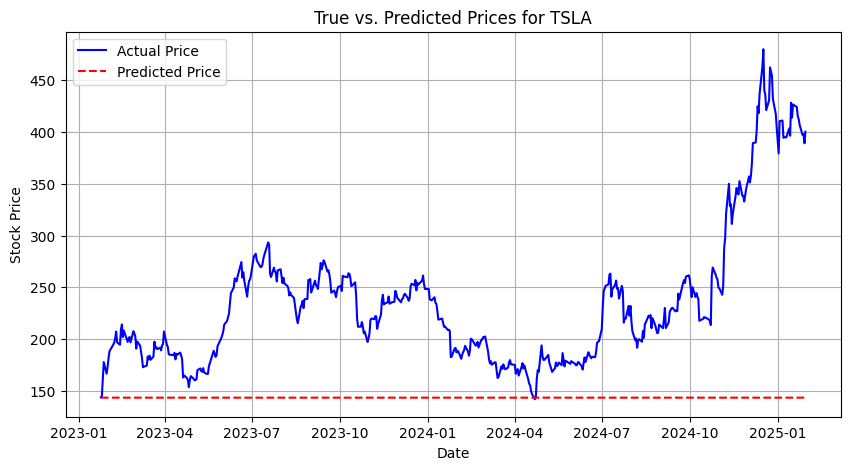

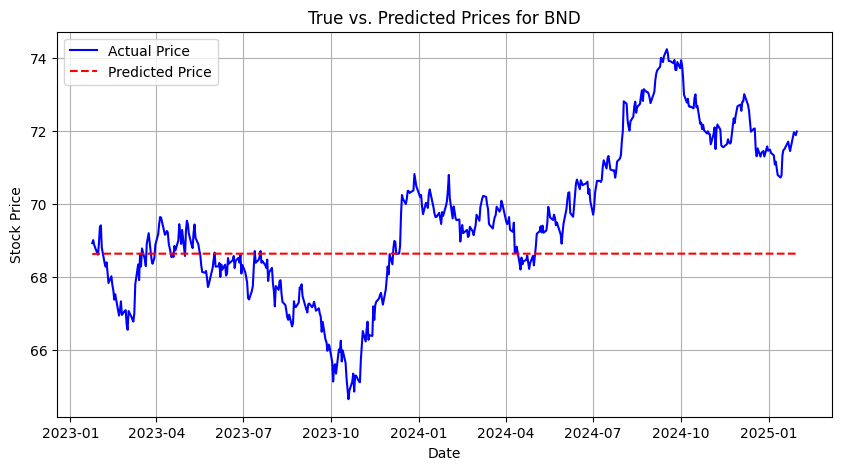

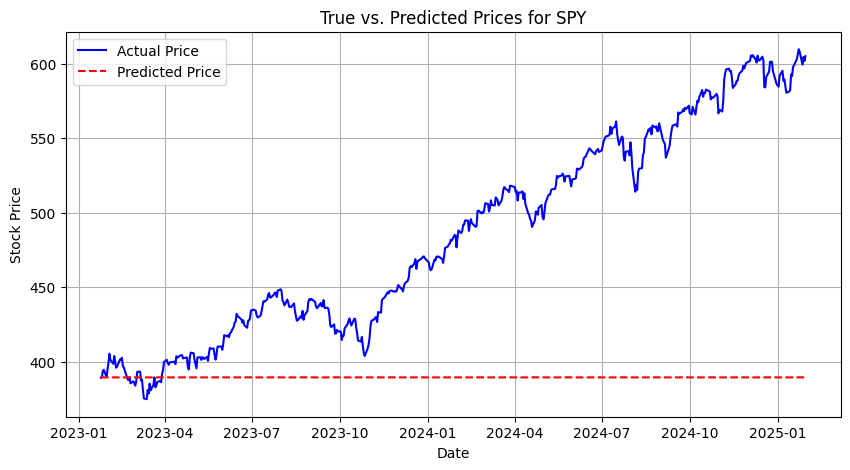

In [80]:
# Plot True vs. Predicted for each ticker
tickers = ["TSLA", "BND","SPY"]
for ticker in tickers:
    # The following line was commented out, causing the error.
    # It's now uncommented and modified to correctly filter the DataFrame.
    df_ticker = forecasts_df[ticker]

    plt.figure(figsize=(10, 5))
    # Now 'df_ticker' is correctly defined and can be used to access the index.
    plt.plot(df_ticker.index, df_ticker['True_Price'], label="Actual Price", color="blue")
    plt.plot(df_ticker.index, df_ticker['Predicted_Price'], label="Predicted Price", color="red", linestyle="dashed")

    plt.title(f"True vs. Predicted Prices for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# **Optimize Portfolio Based on Forecast**

In [81]:
tsla_prices = forecasts_df['TSLA']['Predicted_Price']
bnd_prices = forecasts_df['BND']['Predicted_Price']
spy_prices = forecasts_df['SPY']['Predicted_Price']

In [82]:
# Calculate daily returns for each asset
tsla_returns = tsla_prices.pct_change().dropna()
bnd_returns = bnd_prices.pct_change().dropna()
spy_returns = spy_prices.pct_change().dropna()

# Combine returns into a single DataFrame
returns_df = pd.DataFrame({
    'TSLA': tsla_returns,
    'BND': bnd_returns,
    'SPY': spy_returns
})

In [83]:
returns_df.head()

,TSLA,BND,SPY
Date,,,
2023-01-25,0.001011,0.000061,0.000228
2023-01-26,-0.000486,0.000041,-0.000081
2023-01-27,0.000233,0.000028,0.000029
2023-01-30,-0.000112,0.000019,-0.000010
2023-01-31,0.000054,0.000013,0.000004


In [84]:
# Calculate expected returns (mean returns for each asset)
expected_returns = returns_df.mean()

# Calculate covariance matrix
cov_matrix = returns_df.cov()

# Calculate correlation matrix
corr_matrix = returns_df.corr()

print("Expected Returns:\n", expected_returns)
print("\nCovariance Matrix:\n", cov_matrix)
print("\nCorrelation Matrix:\n", corr_matrix)

Expected Returns:
 TSLA    1.350988e-06
BND     3.689018e-07
SPY     3.326281e-07
dtype: float64

Covariance Matrix:
               TSLA           BND           SPY
TSLA  2.631104e-09  9.131947e-11  5.496082e-10
BND   9.131947e-11  1.325639e-11  2.198276e-11
SPY   5.496082e-10  2.198276e-11  1.175171e-10

Correlation Matrix:
           TSLA       BND       SPY
TSLA  1.000000  0.488970  0.988402
BND   0.488970  1.000000  0.556954
SPY   0.988402  0.556954  1.000000


# **Portfolio Optimization**

In [86]:
# Calculate expected returns (mean returns for each asset)
expected_returns = returns_df.mean()

# Calculate covariance matrix
cov_matrix = returns_df.cov()

# Calculate correlation matrix
corr_matrix = returns_df.corr()

print("Expected Returns:\n", expected_returns)
print("\nCovariance Matrix:\n", cov_matrix)
print("\nCorrelation Matrix:\n", corr_matrix)

# Portfolio Optimization
# To optimize the portfolio, we will calculate the efficient frontier and the optimal portfolio using a method like Monte Carlo simulation.
# ... (rest of your code for portfolio optimization)

Expected Returns:
 TSLA    1.350988e-06
BND     3.689018e-07
SPY     3.326281e-07
dtype: float64

Covariance Matrix:
               TSLA           BND           SPY
TSLA  2.631104e-09  9.131947e-11  5.496082e-10
BND   9.131947e-11  1.325639e-11  2.198276e-11
SPY   5.496082e-10  2.198276e-11  1.175171e-10

Correlation Matrix:
           TSLA       BND       SPY
TSLA  1.000000  0.488970  0.988402
BND   0.488970  1.000000  0.556954
SPY   0.988402  0.556954  1.000000
